## Lib

In [ ]:
pip install hydra-core --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=8c9afed829c300cf5e28d1269a20e1a90216333a0b3f868d5e7843bd9ac6f6bb
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import timm
import os
import cv2
import glob
from tqdm import tqdm
from PIL import Image
import torch
import torchvision.transforms as trans
import torch.nn as nn
import imageio
import hydra
import time
import copy
from omegaconf import DictConfig, OmegaConf
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from hydra.utils import instantiate
from typing import Optional
import torch.nn.functional as F
from torch.nn.modules.loss import _WeightedLoss

## Viz

In [ ]:
df= pd.read_csv('train/label.csv')

In [ ]:
path_vid= glob.glob('train/videos/*.mp4')

In [ ]:
df.head() #0: Fake, 1: Real

,fname,liveness_score
0,1.mp4,0
1,2.mp4,1
2,3.mp4,1
3,5.mp4,0
4,7.mp4,1


In [ ]:
value_count= df['liveness_score'].value_counts()
value_count

1    598
0    570
Name: liveness_score, dtype: int64

<BarContainer object of 2 artists>

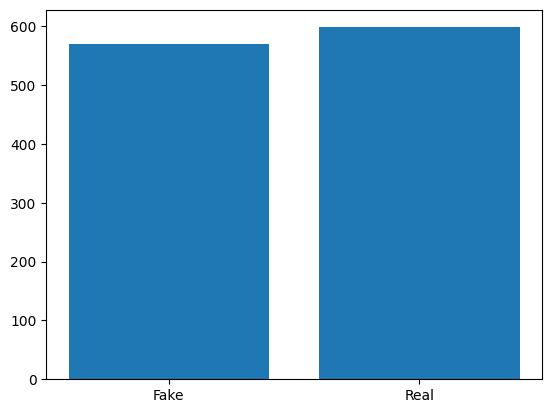

In [ ]:
plt.bar(x= ['Fake', "Real"], height= [value_count[0], value_count[1]])

In [ ]:
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

In [ ]:
def display_video(video):
    fig = plt.figure(figsize=(3,3))  #Display size specification

    mov = []
    for i in range(len(video)):  #Append videos one by one to mov
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    plt.close()
    return anime

In [ ]:
video = imageio.mimread('/content/drive/MyDrive/Pre-Thesis+Thesis/train/train/videos/1.mp4')
HTML(display_video(video).to_html5_video())

## Process data

In [ ]:
input_dir= '/train/videos'
output_dir= '/framevideo'

In [ ]:
def read_video(name):
    cap = cv2.VideoCapture(name)
    frames = []
    fps = cap.get(cv2.CAP_PROP_FPS)
    if not fps:
        fps = 25
    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        # print(count)
        if isinstance(frame, np.ndarray):
            if int(count % round(fps)) == 0:
                frames.append(frame)
            count += 1
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    return frames

In [ ]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114)):
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, ratio, (dw, dh)

In [ ]:
def create_csv(fname, y, input_dir, images_dir, csv_filename):
    csv_file = open(os.path.join(input_dir, csv_filename), "w")
    csv_file.write("fname,liveness_score\n")
    for filename, label in zip(fname, y):
        name = filename.split(".")[0]
        list_image_filename = sorted(
            os.listdir(os.path.join(input_dir, images_dir, name))
        )
        for image_filename in list_image_filename:
            image_path = os.path.join(images_dir.split('/')[-1], name, image_filename)
            csv_file.write(f"{image_path},{label}\n")
    csv_file.close()

In [ ]:
if not os.path.exists(output_dir):
      os.mkdir(output_dir)
filenames = os.listdir(input_dir)
for filename in tqdm(filenames):
    filepath = os.path.join(input_dir, filename)
    name, file_extension = os.path.splitext(filename)

    frames = read_video(filepath)
    output = os.path.join(output_dir, name)
    if not os.path.exists(output):
        os.mkdir(output)

    for idx, frame in enumerate(frames):
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]
        max_size = max(height, width)
        im_pil = Image.fromarray(img)
        im_pil.save(os.path.join(output, str(idx) + ".png"))

100%|██████████| 1168/1168 [1:07:57<00:00,  3.49s/it]


In [ ]:
df= pd.read_csv("/data/test.csv")

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(df['fname'],
                                                   df['liveness_score'],
                                                   test_size= .2,
                                                   random_state= 42,
                                                   stratify= df['liveness_score'])

In [ ]:
X_test, X_val, y_test, y_val= train_test_split(df['fname'],
                                                   df['liveness_score'],
                                                   test_size= .5,
                                                   random_state= 42,
                                                   stratify= df['liveness_score'])

In [ ]:
input_dir= '/data'
images_dir= '/data/framevideo'

In [ ]:
create_csv(X_train, y_train, input_dir, images_dir, 'train.csv')
create_csv(X_test, y_test, input_dir, images_dir, 'test.csv')
create_csv(X_val, y_val, input_dir, images_dir, 'val.csv')

In [ ]:
data_dir= '/content/drive/MyDrive/Pre-Thesis+Thesis/data'

PosixPath('/content/drive/MyDrive/Pre-Thesis+Thesis/data')

In [ ]:
cfg = OmegaConf.load('/content/drive/MyDrive/Pre-Thesis+Thesis/config/baseline.yaml')
augment_config= cfg.dataset.augmentation
transforms= list()

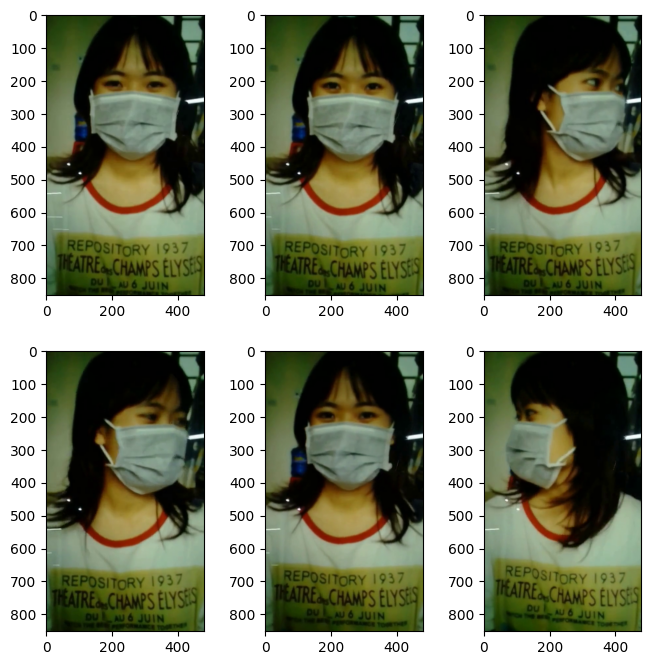

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 2
frame= read_video('/content/drive/MyDrive/Pre-Thesis+Thesis/train/train/videos/1.mp4')
for i in range(1, columns*rows +1):
    img = cv2.cvtColor(frame[i-1], cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(im_pil)
plt.show()

## Dataset

In [ ]:
def get_image_transforms(input_size, augment, augment_config=None):
    transforms = []
    if augment:
        transforms += [trans.Resize([input_size, input_size])]
        for aug in augment_config:
            transforms += [hydra.utils.instantiate(augment_config[aug])]
        transforms += [
            trans.ToTensor(),
            trans.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    else:
        transforms += [
            trans.Resize([input_size, input_size]),
            trans.ToTensor(),
            trans.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    transforms = trans.Compose(transforms)
    return transforms

In [ ]:
class LivenessDataset(Dataset):
    def __init__(self, img_file, img_dir, augment=True, augment_config=False, input_size=256):
        super().__init__()
        self.img_dir = Path(img_dir)
        df = pd.read_csv(img_file)
        self.paths = df.iloc[:, 0]
        self.labels =df.iloc[:, 1]

        self.input_size = input_size
        self.transforms = get_image_transforms(self.input_size, augment, augment_config)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.paths[index])
        image = Image.open(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        label = self.labels[index]
        return image, label

    def __len__(self):
        return len(self.labels)

In [ ]:
input_size= 224
batch_size= 16
img_file= {'train': './data/train.csv',
          'val': './data/val_aug.csv',
           'test': './data/val.csv'}
img_dir= './data'
cfg = OmegaConf.load('./config/baseline.yaml')
cfg_dataset= cfg.dataset

In [ ]:
def read_dataset(input_size, img_file, img_dir, batch_size, num_workers= 0, augment= True, augment_config= None):
  train_dataset= LivenessDataset(input_size= input_size,
                                 img_file= img_file['train'],
                                 img_dir= img_dir,
                                 augment= True,
                                 augment_config= cfg_dataset.augmentation)
  val_dataset= LivenessDataset(input_size= input_size,
                               img_file= img_file['val'],
                               img_dir= img_dir,
                               augment= False,
                               augment_config= None)
  test_dataset= LivenessDataset(input_size= input_size,
                               img_file= img_file['test'],
                               img_dir= img_dir,
                               augment= False,
                               augment_config= None)
  train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=batch_size,
                                                 shuffle= True,
                                                 num_workers= num_workers,
                                                 drop_last= False)
  val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                              batch_size=batch_size,
                                              shuffle= True,
                                              num_workers= num_workers,
                                              drop_last= False)
  test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle= True,
                                              num_workers= num_workers,
                                              drop_last= False)

  return train_dataloader, val_dataloader, test_dataloader

In [ ]:
augment_config= cfg.dataset.augmentation
augment_config

{'aug0': {'_target_': 'torchvision.transforms.RandomResizedCrop', 'size': '${dataset.crop_size}', 'scale': [0.49, 1.0]}, 'aug1': {'_target_': 'torchvision.transforms.RandomHorizontalFlip', 'p': 0.5}, 'aug2': {'_target_': 'torchvision.transforms.GaussianBlur', 'kernel_size': 3, 'sigma': [0.2, 2.0]}, 'aug3': {'_target_': 'torchvision.transforms.RandomVerticalFlip', 'p': 0.2}, 'aug4': {'_target_': 'torchvision.transforms.ColorJitter', 'brightness': 0.0, 'contrast': 0.2, 'saturation': 0.0, 'hue': 0.0}}

In [ ]:
train_dataloader, val_dataloader, test_dataloader= read_dataset(input_size, img_file, img_dir, batch_size, augment_config=augment_config)

## Val_aug

In [ ]:
def get_image_transforms_val(input_size, augment_config=None, is_aug=False):
    transforms = []
    if is_aug:
        for aug in augment_config:
            transforms += [hydra.utils.instantiate(augment_config[aug])]
    else:
        transforms += [
            trans.Resize([input_size, input_size]),
        ]
    transforms = trans.Compose(transforms)
    return transforms

In [ ]:
def transforms_func(image, config):
    transforms = get_image_transforms_val(config.dataset.crop_size, config.dataset.augmentation, config.dataset.is_aug)
    transforms_ori = get_image_transforms_val(config.dataset.crop_size, config.dataset.augmentation, False)
    width, height = image.size
    resize_transforms = trans.Compose([
        trans.CenterCrop((int(0.75 * height), int(0.75 * width))),
        trans.Resize((int(0.375 * height), int(0.375 * width)))
    ])
    image = resize_transforms(image)
    if transforms is not None:
        image_tr = transforms(image)
    if transforms_ori is not None:
        image_ori = transforms_ori(image)
    return image_ori, image_tr

In [ ]:
def aug(config):
    if not os.path.exists(config.dataset.save_dir):
        os.mkdir(config.dataset.save_dir)

    data_dir = config.dataset.data_dir
    df = pd.read_csv(config.dataset.data_list)
    paths = df.iloc[:, 0]
    labels = list(map(str, df.iloc[:, 1]))
    new_paths = []
    new_labels = []

    for path, label in zip(paths, labels):
        img_path = os.path.join(data_dir, path)
        print(img_path)
        image = Image.open(img_path)
        image_ori, image = transforms_func(image, config)
        save_path = os.path.join(config.dataset.save_dir, path)

        dirname = os.path.dirname(save_path)
        if not os.path.exists(dirname):
            os.makedirs(dirname, exist_ok=True)

        image.save(save_path)

        filename, file_extension = os.path.splitext(path)
        path_ori = filename + '_ori' + file_extension
        save_path_ori = os.path.join(config.dataset.save_dir, path_ori)
        image_ori.save(save_path_ori)
        path = os.path.join(os.path.basename(config.dataset.save_dir), path)
        path_ori = os.path.join(os.path.basename(config.dataset.save_dir), path_ori)
        new_paths.extend([path,path_ori])
        new_labels.extend([label,label])

    out_df = pd.DataFrame(
    {'fname': new_paths,
     'liveness_score': new_labels
    })
    out_df.to_csv(config.dataset.save_list, index=False)

In [ ]:
cfg_aug = OmegaConf.load('/content/drive/MyDrive/Pre-Thesis+Thesis/config/aug.yaml')

In [ ]:
aug(cfg_aug)

## Print features and labels img

label: 0


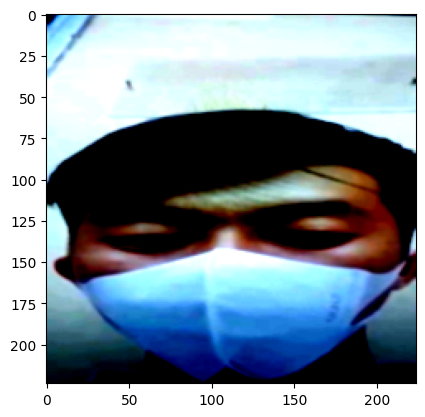

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[1].squeeze()
label = train_labels[1]
img= img.permute(1,2,0)
plt.imshow(img)
print(f'label: {label}')

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
val_features, val_labels = next(iter(val_dataloader))

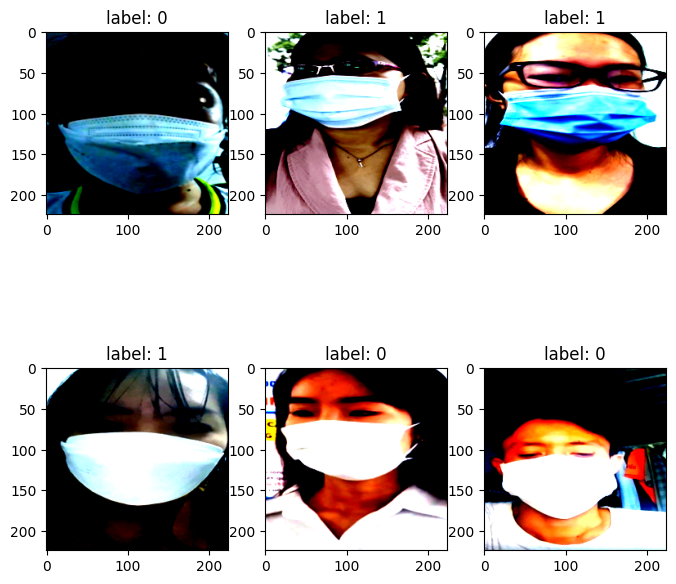

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = val_features[i-1].squeeze()
    label = val_labels[i-1]
    img= img.permute(1,2,0)
    fig.add_subplot(rows, columns, i)
    plt.title(f'label: {label}')
    plt.imshow(img)
plt.show()

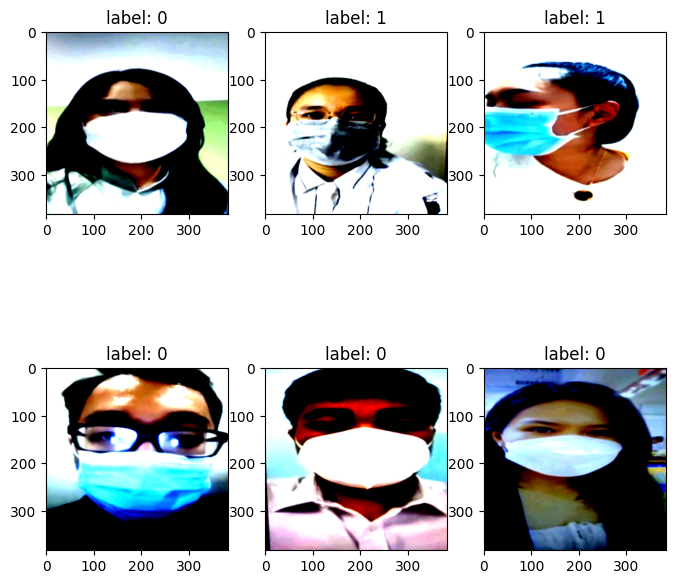

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = train_features[i-1].squeeze()
    label = train_labels[i-1]
    img= img.permute(1,2,0)
    fig.add_subplot(rows, columns, i)
    plt.title(f'label: {label}')
    plt.imshow(img)
plt.show()

## Model

In [ ]:
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(
        self, smoothing: float = 0.2, reduction="mean", weight=None, training=True
    ):
        super().__init__()
        self.epsilon = smoothing
        self.reduction = reduction
        self.weight = weight
        self.training = training

    def reduce_loss(self, loss):
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

    def linear_combination(self, x, y):
        # print(x, y, self.epsilon)
        return self.epsilon * x + (1 - self.epsilon) * y

    def forward(self, preds, target, TTA=False):
        target = target.to(dtype=torch.long)
        target = torch.squeeze(target)
        if self.weight is not None:
            self.weight = self.weight.to(preds.device)
        # print('---------------------')
        # print(target.shape, preds.shape)
        if self.training:
            # print('Train')
            n = preds.size(-1)
            log_preds = F.log_softmax(preds, dim=-1)
            loss = self.reduce_loss(-log_preds.sum(dim=-1))
            # print(log_preds.shape)
            nll = F.nll_loss(
                log_preds, target, reduction=self.reduction, weight=self.weight
            )
            return self.linear_combination(loss / n, nll)
        else:
            if not TTA:
                log_preds = F.log_softmax(preds, dim=-1)
            else:
                log_preds = preds
            return torch.nn.functional.cross_entropy(preds, target, weight=self.weight)

In [ ]:
class SwinTransformer(nn.Module):
    def __init__(self, model_name, n_class=2, pretrained=True, **kwargs):
        super().__init__()
        backbone = timm.create_model(model_name, pretrained=pretrained, **kwargs)
        n_features = backbone.head.in_features
        self.backbone = backbone
        self.dropout = nn.Dropout(0.5)
        self.classifier1 = nn.Linear(n_features, 512)
        self.classifier2 = nn.Linear(512,n_class)
        self.relu= nn.ReLU()

    def forward_features(self, x):
        x = self.backbone.forward_features(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.mean(dim=1)
        x = self.classifier2(x)
        return x[:,-1]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device available now: {device}')

Device available now: cuda


In [ ]:
from timm.loss import LabelSmoothingCrossEntropy

In [ ]:
model= SwinTransformer('swin_tiny_patch4_window7_224')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 3e-5, weight_decay= 1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma= 0.2)
loss_fn = LabelSmoothingCrossEntropy()
loss_fn.to(device)

epochs= 30

In [ ]:
output_dir= './model_train'
path_best= './model_train/best_model.pth'
path_current= './model_train/current_model.pth'

In [ ]:
checkpoint = torch.load(path_current)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
val_accuracy = checkpoint['val_acc']

model.eval()

In [ ]:
lr = next(iter(optimizer.param_groups))['lr']

In [ ]:
train_loss_hist= []
train_accu_hist= []
val_loss_hist= []
val_accu_hist= []
if os.path.exists(path_best):
  best_acc= torch.load(path_best)['best_acc']
else:
  best_acc= 0
if os.path.exists(path_current):
  epoch= torch.load(path_current)['epoch']
else:
  epoch= 0

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

for epoch in range(epoch, epochs):
    f = open(os.path.join(output_dir, 'log.txt'), 'a')
    train_size = len(train_dataloader.dataset)
    val_size = len(val_dataloader.dataset)
    train_run_loss, val_run_loss = 0, 0
    train_run_accuracy, val_run_accuracy= 0, 0
    print(f'Epoch [{epoch}/{epochs}]')
    f.write(f'\nEpoch [{epoch}/{epochs}]')
    print('--------------------------')
    model.train()
    #loop_train= tqdm(train_dataloader, total= len(train_dataloader))
    for img, label in tqdm(train_dataloader):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        logits = model(img)
        loss = loss_fn(logits, label)
        _, preds = torch.max(logits, 1)
        # Backpropagation
        loss.backward()
        optimizer.step()
        train_run_loss += loss.item()*img.size(0)
        train_run_accuracy += torch.sum(preds == label.data)
    train_loss = train_run_loss/train_size
    train_accuracy = train_run_accuracy/train_size
    scheduler.step()
    print(f'\n train_los= {train_loss:.4f} \t train_accuracy= {100*train_accuracy:.4f}%')
    f.write(f'\n train_los= {train_loss:.4f} \t train_accuracy= {100*train_accuracy:.4f}%')
    print('--------------------------//--------------------------')
    # evaluate
    model.eval()
    #loop_val= tqdm(val_dataloader, total= len(val_dataloader))
    with torch.no_grad():
        for img, label in tqdm(val_dataloader):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss= loss_fn(logits, label)
            _, preds = torch.max(logits, 1)
            val_run_loss += loss.item()*img.size(0)
            val_run_accuracy += torch.sum(preds == label.data)

        val_loss = val_run_loss/val_size
        val_accuracy = val_run_accuracy/val_size
    print(f'\n val_loss= {val_loss:.4f} \t val_accuracy= {100*val_accuracy:.4f}%')
    f.write(f'\n val_los= {val_loss:.4f} \t val_accuracy= {100*val_accuracy:.4f}%')
    f.write('\nSaving best model!\n')
    train_loss_hist.append(train_loss)
    train_accu_hist.append(train_accuracy)
    val_loss_hist.append(val_loss)
    val_accu_hist.append(val_accuracy)
    print('Saving checkpoint')
    f.write('\nSaving checkpoint\n')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_acc': val_accuracy
    }, os.path.join(output_dir, 'current_model' + '.pth'))

    if val_accuracy > best_acc:
        print('Saving best model')
        f.write('\nSaving best model!\n')
        best_acc = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': val_accuracy
        }, os.path.join(output_dir, 'best_model' + '.pth'))
    f.close()
    print('--------------------------//--------------------------')


Epoch [7/30]
--------------------------


100%|██████████| 314/314 [43:32<00:00,  8.32s/it]



 train_los= 0.2107 	 train_accuracy= 99.6208%
--------------------------//--------------------------


100%|██████████| 155/155 [20:22<00:00,  7.88s/it]



 val_loss= 0.2713 	 val_accuracy= 95.9887%
Saving checkpoint
Saving best model
--------------------------//--------------------------
Epoch [8/30]
--------------------------


100%|██████████| 314/314 [06:33<00:00,  1.25s/it]



 train_los= 0.2128 	 train_accuracy= 99.4411%
--------------------------//--------------------------


100%|██████████| 155/155 [00:46<00:00,  3.33it/s]



 val_loss= 0.2787 	 val_accuracy= 95.0567%
Saving checkpoint
--------------------------//--------------------------
Epoch [9/30]
--------------------------


100%|██████████| 314/314 [06:36<00:00,  1.26s/it]



 train_los= 0.2119 	 train_accuracy= 99.5010%
--------------------------//--------------------------


100%|██████████| 155/155 [00:47<00:00,  3.27it/s]



 val_loss= 0.2740 	 val_accuracy= 95.8671%
Saving checkpoint
--------------------------//--------------------------
Epoch [10/30]
--------------------------


100%|██████████| 314/314 [06:33<00:00,  1.25s/it]



 train_los= 0.2084 	 train_accuracy= 99.5609%
--------------------------//--------------------------


100%|██████████| 155/155 [00:46<00:00,  3.32it/s]



 val_loss= 0.2772 	 val_accuracy= 95.5024%
Saving checkpoint
--------------------------//--------------------------
Epoch [11/30]
--------------------------


100%|██████████| 314/314 [06:38<00:00,  1.27s/it]



 train_los= 0.2093 	 train_accuracy= 99.5409%
--------------------------//--------------------------


100%|██████████| 155/155 [00:47<00:00,  3.29it/s]



 val_loss= 0.2771 	 val_accuracy= 95.5835%
Saving checkpoint
--------------------------//--------------------------
Epoch [12/30]
--------------------------


100%|██████████| 314/314 [06:34<00:00,  1.26s/it]



 train_los= 0.2088 	 train_accuracy= 99.5010%
--------------------------//--------------------------


100%|██████████| 155/155 [00:47<00:00,  3.25it/s]



 val_loss= 0.2675 	 val_accuracy= 96.1102%
Saving checkpoint
Saving best model
--------------------------//--------------------------
Epoch [13/30]
--------------------------


100%|██████████| 314/314 [06:35<00:00,  1.26s/it]



 train_los= 0.2060 	 train_accuracy= 99.6806%
--------------------------//--------------------------


100%|██████████| 155/155 [00:46<00:00,  3.30it/s]



 val_loss= 0.2648 	 val_accuracy= 96.3128%
Saving checkpoint
Saving best model
--------------------------//--------------------------
Epoch [14/30]
--------------------------


100%|██████████| 314/314 [06:06<00:00,  1.17s/it]



 train_los= 0.2056 	 train_accuracy= 99.8204%
--------------------------//--------------------------


100%|██████████| 155/155 [00:44<00:00,  3.45it/s]



 val_loss= 0.2727 	 val_accuracy= 95.8266%
Saving checkpoint
--------------------------//--------------------------
Epoch [15/30]
--------------------------


100%|██████████| 314/314 [06:04<00:00,  1.16s/it]



 train_los= 0.2071 	 train_accuracy= 99.6407%
--------------------------//--------------------------


100%|██████████| 155/155 [00:45<00:00,  3.38it/s]



 val_loss= 0.2710 	 val_accuracy= 96.1102%
Saving checkpoint
--------------------------//--------------------------
Epoch [16/30]
--------------------------


100%|██████████| 314/314 [06:06<00:00,  1.17s/it]



 train_los= 0.2057 	 train_accuracy= 99.7804%
--------------------------//--------------------------


100%|██████████| 155/155 [00:44<00:00,  3.46it/s]



 val_loss= 0.2756 	 val_accuracy= 95.3809%
Saving checkpoint
--------------------------//--------------------------
Epoch [17/30]
--------------------------


100%|██████████| 314/314 [06:05<00:00,  1.16s/it]



 train_los= 0.2055 	 train_accuracy= 99.7804%
--------------------------//--------------------------


100%|██████████| 155/155 [00:44<00:00,  3.45it/s]



 val_loss= 0.2811 	 val_accuracy= 95.2188%
Saving checkpoint
--------------------------//--------------------------
Epoch [18/30]
--------------------------


100%|██████████| 314/314 [06:07<00:00,  1.17s/it]



 train_los= 0.2045 	 train_accuracy= 99.8004%
--------------------------//--------------------------


100%|██████████| 155/155 [00:44<00:00,  3.48it/s]



 val_loss= 0.2755 	 val_accuracy= 95.5429%
Saving checkpoint
--------------------------//--------------------------
Epoch [19/30]
--------------------------


100%|██████████| 314/314 [06:05<00:00,  1.16s/it]



 train_los= 0.2054 	 train_accuracy= 99.7405%
--------------------------//--------------------------


100%|██████████| 155/155 [00:45<00:00,  3.42it/s]



 val_loss= 0.2748 	 val_accuracy= 95.5024%
Saving checkpoint
--------------------------//--------------------------
Epoch [20/30]
--------------------------


100%|██████████| 314/314 [06:06<00:00,  1.17s/it]



 train_los= 0.2051 	 train_accuracy= 99.8004%
--------------------------//--------------------------


100%|██████████| 155/155 [00:46<00:00,  3.37it/s]



 val_loss= 0.2780 	 val_accuracy= 95.2998%
Saving checkpoint
--------------------------//--------------------------
Epoch [21/30]
--------------------------


100%|██████████| 314/314 [06:07<00:00,  1.17s/it]



 train_los= 0.2044 	 train_accuracy= 99.8603%
--------------------------//--------------------------


100%|██████████| 155/155 [00:45<00:00,  3.44it/s]



 val_loss= 0.2672 	 val_accuracy= 96.2723%
Saving checkpoint
--------------------------//--------------------------
Epoch [22/30]
--------------------------


100%|██████████| 314/314 [06:06<00:00,  1.17s/it]



 train_los= 0.2053 	 train_accuracy= 99.7405%
--------------------------//--------------------------


100%|██████████| 155/155 [00:44<00:00,  3.48it/s]



 val_loss= 0.2689 	 val_accuracy= 96.1102%
Saving checkpoint
--------------------------//--------------------------
Epoch [23/30]
--------------------------


100%|██████████| 314/314 [06:06<00:00,  1.17s/it]



 train_los= 0.2050 	 train_accuracy= 99.8204%
--------------------------//--------------------------


100%|██████████| 155/155 [00:45<00:00,  3.43it/s]



 val_loss= 0.2717 	 val_accuracy= 96.0292%
Saving checkpoint
--------------------------//--------------------------
Epoch [24/30]
--------------------------


100%|██████████| 314/314 [06:08<00:00,  1.17s/it]



 train_los= 0.2060 	 train_accuracy= 99.7006%
--------------------------//--------------------------


100%|██████████| 155/155 [00:44<00:00,  3.45it/s]



 val_loss= 0.2724 	 val_accuracy= 95.9076%
Saving checkpoint
--------------------------//--------------------------
Epoch [25/30]
--------------------------


100%|██████████| 314/314 [06:12<00:00,  1.19s/it]



 train_los= 0.2047 	 train_accuracy= 99.8403%
--------------------------//--------------------------


100%|██████████| 155/155 [00:49<00:00,  3.14it/s]



 val_loss= 0.2726 	 val_accuracy= 95.8671%
Saving checkpoint
--------------------------//--------------------------
Epoch [26/30]
--------------------------


100%|██████████| 314/314 [06:40<00:00,  1.28s/it]



 train_los= 0.2041 	 train_accuracy= 99.8204%
--------------------------//--------------------------


100%|██████████| 155/155 [00:48<00:00,  3.21it/s]



 val_loss= 0.2745 	 val_accuracy= 95.6240%
Saving checkpoint
--------------------------//--------------------------
Epoch [27/30]
--------------------------


100%|██████████| 314/314 [06:33<00:00,  1.25s/it]



 train_los= 0.2054 	 train_accuracy= 99.7206%
--------------------------//--------------------------


100%|██████████| 155/155 [00:47<00:00,  3.28it/s]



 val_loss= 0.2743 	 val_accuracy= 95.6240%
Saving checkpoint
--------------------------//--------------------------
Epoch [28/30]
--------------------------


100%|██████████| 314/314 [06:06<00:00,  1.17s/it]



 train_los= 0.2055 	 train_accuracy= 99.7405%
--------------------------//--------------------------


100%|██████████| 155/155 [00:45<00:00,  3.44it/s]



 val_loss= 0.2742 	 val_accuracy= 95.6240%
Saving checkpoint
--------------------------//--------------------------
Epoch [29/30]
--------------------------


  0%|          | 0/314 [00:00<?, ?it/s]

In [ ]:
epoch_f1 = f1_score(labels.cpu().data, preds.cpu(), average='micro')

## Test eval

In [ ]:
def get_model(model_base, checkpoint_path):
    model = model_base

    ckpt = torch.load( checkpoint_path)
    model.load_state_dict(ckpt["model_state_dict"])

    return model

In [ ]:
checkpoint_path= '/model_train/best_model.pth'

In [ ]:
model_ft= get_model(model, checkpoint_path)

In [ ]:
classes= test_dataloader.dataset.labels

In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(2))
class_total = list(0 for i in range(2))
model_ft.eval()

for data, target in tqdm(test_dataloader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
for i in range(2):
    print(f"\nTest Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]:.2f}% ({np.sum(class_correct[i])}/{np.sum(class_total[i])})")
print(f"\nTest Accuracy is {100*np.sum(class_correct)/np.sum(class_total):.2f}% ({np.sum(class_correct)}/{np.sum(class_total)})")

100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Test Accuracy of 0: 96.52% (111/115)

Test Accuracy of 1: 100.00% (132/132)

Test Accuracy is 98.38% (243/247)
